# Theoretical questions

**Q1: Why is the KL Divergence term important in the VAE loss function?**

Without the KL term, the loss function (cross-entropy) measures only the difference between the original training image and its reconstruction by the VAE. In this case, the model behaves like a deterministic autoencoder: the latent space isn't probabilistic, what makes image generation impossible.

The KL Divergence term arises from modeling each latent point with a Gaussian distribution and penalizing its deviation from a fixed prior state. This term forces latent representations of different inputs to occupy a shared, continuous region of the latent space, making it smooth. As a result, the model can generalize from finite datasets and generate new, realistic images by sampling from the latent space.

**Q2: How does the reparametrization trick enable backpropagation through the stochastic layers of a VAE?**

The latent variable z dependance on the probabilistic parameters μ and σ obeys Normal distribution formula, what makes differentiation and backpropagation through the sampling operation impossible. The reparameterization trick resolves this by expressing z as a linear function of μ and σ, hiding nonlinearity inside independent random variable 𝜀. This separates the stochasticity from the network parameters, allowing gradients to flow through μ and σ during backpropagation and enabling the encoder to be trained effectively.

**Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?**

A VAE uses a probabilistic latent space because it allows the model to capture uncertainty in the data, ensures continuity and smoothness of the latent manifold, and enables generation of new, diverse samples. In contrast, a fixed latent space maps each input to a single point, which prevents meaningful interpolation and reliable sampling from the latent space.

**Q4: What role does KL Divergence play in ensuring a smooth latent space?**

This question pretty close to 1-st one. KL Divergence regularizes the latent distributions by forcing them to stay close to a shared prior. This encourages nearby inputs to map to nearby latent vectors, reducing gaps and overlaps in the latent space, and ensures a continuous, smooth latent manifold suitable for interpolation and generation.

# VAE training part

In [ ]:
# !pip install torch
# !pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# VAE Architecture: fully conected

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3*32*32))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
# VAE Architecture: with convolution layers

class VAE_conv(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_conv, self).__init__()

        # Encoder
        self.cl_1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)        # 3x32x32 -> 32x16x16
        self.cl_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)       # 32x16x16 -> 64х8х8
        self.cl_3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)      # 64x8x8 -> 128х4х4
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.cl_tr_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # 128x4x4 -> 64x8x8
        self.cl_tr_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # 64x8x8 -> 32x16x16
        self.cl_tr_3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1) # 32x16x16 -> 3x32x32

    def encode(self, x):
        h1 = torch.relu(self.cl_1(x))
        h2 = torch.relu(self.cl_2(h1))
        h3 = torch.relu(self.cl_3(h2))
        h3 = h3.view(h3.size(0), -1)
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = torch.relu(self.fc(z))
        h4 = h4.view(h4.size(0), 128, 4, 4)
        h5 = torch.relu(self.cl_tr_1(h4))
        h6 = torch.relu(self.cl_tr_2(h5))
        return torch.sigmoid(self.cl_tr_3(h6))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# Loss function

def loss_function(recon_x, x, mu, logvar):
    beta = 0.1
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [ ]:
# Training the VAE

def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}') if epoch % 10 == 0 else None

In [ ]:
# Load MNIST dataset and run the training
# initial cell is splitted into 2: 1/2

# transform = transforms.ToTensor()
# train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
# Load CIFAR 10 dataset

transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=512, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


In [ ]:
# # initial cell is splitted into 2: 2/2

# INITIAL fully-connected VAE

vae_fc = VAE(input_dim=3*32*32, hidden_dim=400, latent_dim=20)
vae_fc.to(device)
optimizer = optim.Adam(vae_fc.parameters(), lr=1e-3)

for epoch in range(1, 201): # 100 epoches = 37 min
    train(vae_fc, train_loader, optimizer, epoch)

    if epoch % 10 == 0:
      test_loss = 0
      with torch.no_grad():
          for x, _ in test_loader:
              x= x.to(device)
              recon_x, mu, logvar = vae_fc(x)
              loss = loss_function(recon_x, x, mu, logvar)
              test_loss += loss.item()

      test_loss /= len(test_loader.dataset)
      print(f"--------/ Test loss: {test_loss:.4f}")

Epoch 10, Loss: 1812.549465
--------/ Test loss: 1815.2351
Epoch 20, Loss: 1809.45374625
--------/ Test loss: 1812.4142
Epoch 30, Loss: 1807.367515
--------/ Test loss: 1811.1020
Epoch 40, Loss: 1806.39679375
--------/ Test loss: 1809.6803
Epoch 50, Loss: 1804.7891275
--------/ Test loss: 1808.6059
Epoch 60, Loss: 1803.8925475
--------/ Test loss: 1807.9102
Epoch 70, Loss: 1803.27110375
--------/ Test loss: 1807.5861
Epoch 80, Loss: 1802.4311025
--------/ Test loss: 1807.1732
Epoch 90, Loss: 1802.1638175
--------/ Test loss: 1806.7013
Epoch 100, Loss: 1801.4088
--------/ Test loss: 1806.1671
Epoch 110, Loss: 1800.69595375
--------/ Test loss: 1805.9982
Epoch 120, Loss: 1800.58238625
--------/ Test loss: 1805.2545
Epoch 130, Loss: 1800.14443
--------/ Test loss: 1805.4038
Epoch 140, Loss: 1799.89722125
--------/ Test loss: 1805.3731
Epoch 150, Loss: 1799.6399425
--------/ Test loss: 1804.9430
Epoch 160, Loss: 1799.37728375
--------/ Test loss: 1804.7105
Epoch 170, Loss: 1799.07917375
--

In [ ]:
# MODIFIED VAE with convolutions

vae_conv = VAE_conv(latent_dim=512)
vae_conv.to(device)
optimizer = optim.Adam(vae_conv.parameters(), lr=1e-3)

for epoch in range(1, 201):
    train(vae_conv, train_loader, optimizer, epoch)

    if epoch % 10 == 0:
      test_loss = 0
      with torch.no_grad():
          for x, _ in test_loader:
              x= x.to(device)
              recon_x, mu, logvar = vae_conv(x)
              loss = loss_function(recon_x, x, mu, logvar)
              test_loss += loss.item()

      test_loss /= len(test_loader.dataset)
      print(f"--------/ Test loss: {test_loss:.4f}")

Epoch 10, Loss: 1778.41431375
--------/ Test loss: 1779.1217
Epoch 20, Loss: 1757.8470875
--------/ Test loss: 1759.8213
Epoch 30, Loss: 1751.01580875
--------/ Test loss: 1753.5017
Epoch 40, Loss: 1746.4512225
--------/ Test loss: 1749.2823
Epoch 50, Loss: 1743.78883
--------/ Test loss: 1746.8077
Epoch 60, Loss: 1742.55801375
--------/ Test loss: 1745.1399
Epoch 70, Loss: 1741.311085
--------/ Test loss: 1744.1506
Epoch 80, Loss: 1739.80560125
--------/ Test loss: 1742.9182
Epoch 90, Loss: 1739.09200125
--------/ Test loss: 1742.1085
Epoch 100, Loss: 1738.15801
--------/ Test loss: 1741.4692
Epoch 110, Loss: 1737.75142875
--------/ Test loss: 1741.6101
Epoch 120, Loss: 1736.96075375
--------/ Test loss: 1740.4411
Epoch 130, Loss: 1737.453295
--------/ Test loss: 1740.0166
Epoch 140, Loss: 1736.10073625
--------/ Test loss: 1739.8466
Epoch 150, Loss: 1735.8084275
--------/ Test loss: 1739.3548
Epoch 160, Loss: 1735.24095875
--------/ Test loss: 1738.9617
Epoch 170, Loss: 1735.5278125


In [ ]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        img = generated_images[i].view(3, 32, 32).permute(1, 2, 0)
        axs[i].imshow( img )
        axs[i].axis('off')
    plt.show()

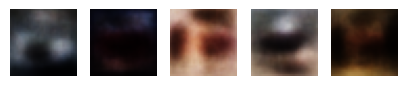

In [ ]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20

generate_images(vae_fc, num_images=5, latent_dim=20)

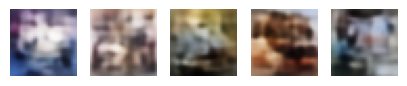

In [ ]:
generate_images(vae_conv, num_images=5, latent_dim=512)

In [ ]:
import random

batch,_ = next(iter(test_loader))

i_a, i_b = random.sample(range(x.size(0)), 2)
img_A = batch[i_a : i_a+1].to(device)
img_B = batch[i_b : i_b+1].to(device)

vae_conv.eval()
with torch.no_grad():
    mu_A, logvar_A = vae_conv.encode(img_A)
    mu_B, logvar_B = vae_conv.encode(img_B)

points = torch.linspace(0, 1, 10).to(device)

with torch.no_grad():
    z_interp = torch.stack([(1-p)*mu_A + p*mu_B  for  p in points]).squeeze(1)
    generated = vae_conv.decode(z_interp).cpu()

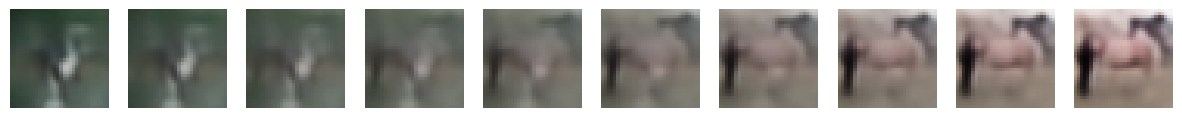

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img = generated[i].permute(1, 2, 0).clamp(0, 1)
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

# CelebA dataset

In [ ]:
# import dataset

transform = transforms.Compose([ transforms.CenterCrop(178), transforms.Resize(64), transforms.ToTensor(), transforms.Normalize( mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] ) ])
train_dataset = datasets.CelebA( './data', split="train", download=True, transform=transform )
test_dataset = datasets.CelebA( './data', split="test", download=True, transform=transform )

train_loader = torch.utils.data.DataLoader( train_dataset, batch_size=512, shuffle=True )
test_loader = torch.utils.data.DataLoader( test_dataset, batch_size=512, shuffle=False )

In [ ]:
# new loss function

import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    beta=0.001
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

In [ ]:
# update VAE a little bit

class VAE_biggest(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_biggest, self).__init__()

        # Encoder
        self.cl_0 = nn.Conv2d(3, 3, kernel_size=4, stride=2, padding=1)         # 3x64x64 -> 3x32x32
        self.cl_1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)        # 3x32x32 -> 32x16x16
        self.cl_2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)       # 32x16x16 -> 64х8х8
        self.cl_3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)      # 64x8x8 -> 128х4х4
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)

        # Decoder
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.cl_tr_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # 128x4x4 -> 64x8x8
        self.cl_tr_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # 64x8x8 -> 32x16x16
        self.cl_tr_3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1) # 32x16x16 -> 3x32x32
        self.cl_tr_0 = nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1) # 3x16x16 -> 3x64x64

    def encode(self, x):
        h0 = torch.relu(self.cl_0(x))
        h1 = torch.relu(self.cl_1(h0))
        h2 = torch.relu(self.cl_2(h1))
        h3 = torch.relu(self.cl_3(h2))
        h3 = h3.view(h3.size(0), -1)
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = torch.relu(self.fc(z))
        h4 = h4.view(h4.size(0), 128, 4, 4)
        h5 = torch.relu(self.cl_tr_1(h4))
        h6 = torch.relu(self.cl_tr_2(h5))
        h7 = torch.relu(self.cl_tr_3(h6))
        return torch.tanh(self.cl_tr_0(h7))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [19]:
# training

vae_biggest = VAE_biggest(latent_dim=512)
vae_biggest.to(device)
optimizer = optim.Adam(vae_biggest.parameters(), lr=1e-3)

for epoch in range(1, 151):
    train(vae_biggest, train_loader, optimizer, epoch)

    if epoch % 10 == 0:
      test_loss = 0
      with torch.no_grad():
          for x, _ in test_loader:
              x= x.to(device)
              recon_x, mu, logvar = vae_biggest(x)
              loss = loss_function(recon_x, x, mu, logvar)
              test_loss += loss.item()

      test_loss /= len(test_loader.dataset)
      print(f"--------/ Test loss: {test_loss:.4f}")

Epoch 10, Loss: 290.9063346670148
--------/ Test loss: 282.3948
Epoch 20, Loss: 223.1396701442219
--------/ Test loss: 218.9699
Epoch 30, Loss: 191.97423780487804
--------/ Test loss: 187.8691
Epoch 40, Loss: 174.24345505736622
--------/ Test loss: 175.4434
Epoch 50, Loss: 161.1125070075874
--------/ Test loss: 161.7555
Epoch 60, Loss: 153.61752813594336
--------/ Test loss: 150.8328


KeyboardInterrupt: 

In [20]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(device)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        img = generated_images[i].view(3, 64, 64).permute(1, 2, 0)
        axs[i].imshow( img )
        axs[i].axis('off')
    plt.show()

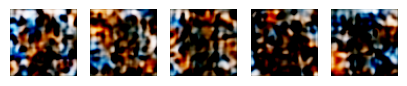

In [22]:
# generate a couple of images

generate_images(vae_biggest, num_images=5, latent_dim=512)

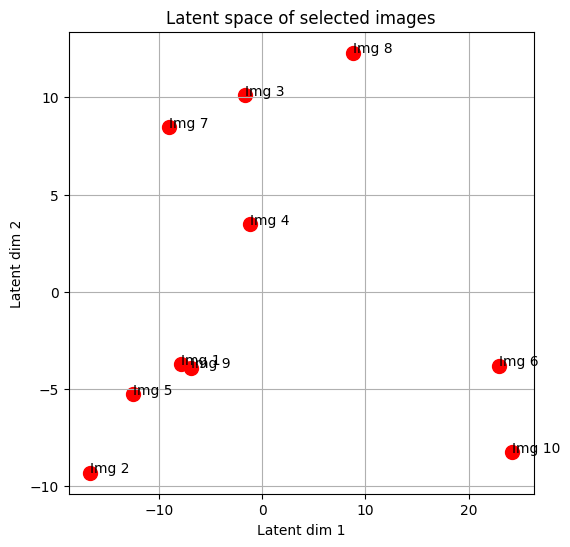

In [23]:
# points in latent space

from sklearn.decomposition import PCA

vae_biggest.eval()

x_batch, _ = next(iter(test_loader))
x_sample = x_batch[:10].to(device)

with torch.no_grad():
    mu, _ = vae_biggest.encode(x_sample)
    z = mu.cpu().numpy()

if z.shape[1] > 2:
    z_2d = PCA(n_components=2).fit_transform(z)
else:
    z_2d = z

plt.figure(figsize=(6,6))
plt.scatter(z_2d[:,0], z_2d[:,1], c='red', s=100)

for i in range(10):
    plt.text(z_2d[i,0]+0.01, z_2d[i,1]+0.01, f'Img {i+1}')

plt.title("Latent space of selected images")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.grid(True)
plt.show()